In [1]:
from generate_data import get_reference_population, population, get_population_model
import numpy as np
from scipy.optimize import minimize
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [2]:
# Stable initial condition: x1 = 5*x2-10*u, np. x, u = [(50, 20), 5]
global k, vk

Ts = 0.1

N = 10
Nu = 6
Lambda = 5e-5

x0 = [50, 20]
y_zad = get_reference_population(x0)

kmax = len(y_zad)

u = 5 * np.ones(kmax+Nu+N)
x = np.zeros((kmax+N, 2))

x[0:5, :] = x0

In [3]:
def cost_function(deltau, model=None, w=[1, 1]):
    u[k:k+Nu] = (np.tril(np.ones((Nu, Nu)), 0) @ deltau.reshape(-1, 1) + u[k-1] * np.ones((Nu,1))).reshape(-1)
    u[k+Nu:k+N+1] = u[k+Nu-1]

    if model is not None:
        x[k] = model.simulate(x[k-1], t=2, u=np.array([u[k]]))[-1] + vk
        for p in range(1, N):
            x[k+p] = model.simulate(x[k+p-1], t=2, u=np.array([u[k+p-1]]))[-1] + vk
    else:
        x[k] = population(t=0, state=x[k-1], T=Ts, u=u[k])
        for p in range(1, N):
            x[k+p] = population(t=0, state=x[k+p-1], T=Ts, u=u[k+p-1])

    return norm((y_zad[k]*w).reshape(-1, 1)*np.ones((1, N)) - (x[k:k+N]*w).T, 2) + Lambda * norm(deltau, 2)

In [4]:
model = get_population_model(x0, Ts, thr=1e-4, deg=1)

(x1)[k+1] = 5.4650 1 + 0.9967 x1[k] + -0.2485 x2[k] + -0.3644 u[k]
(x2)[k+1] = -1.0930 1 + 0.0107 x1[k] + 0.9997 x2[k] + 0.1729 u[k]


In [5]:
state = x0
for k in range(5, kmax):
    xmod =  model.simulate(state, t=2, u=np.array([u[k-1]]))[-1]
    state = population(t=0, state=state, T=Ts, u=u[k-1])

    x[k, :] = state
    vk = state - xmod

    du = minimize(cost_function, args=(None, [0, 1]), x0 = 5*np.ones(Nu), method='SLSQP')
    u[k] = u[k] + du.x[0]
    u[k] = np.clip(u[k], 0, 10)

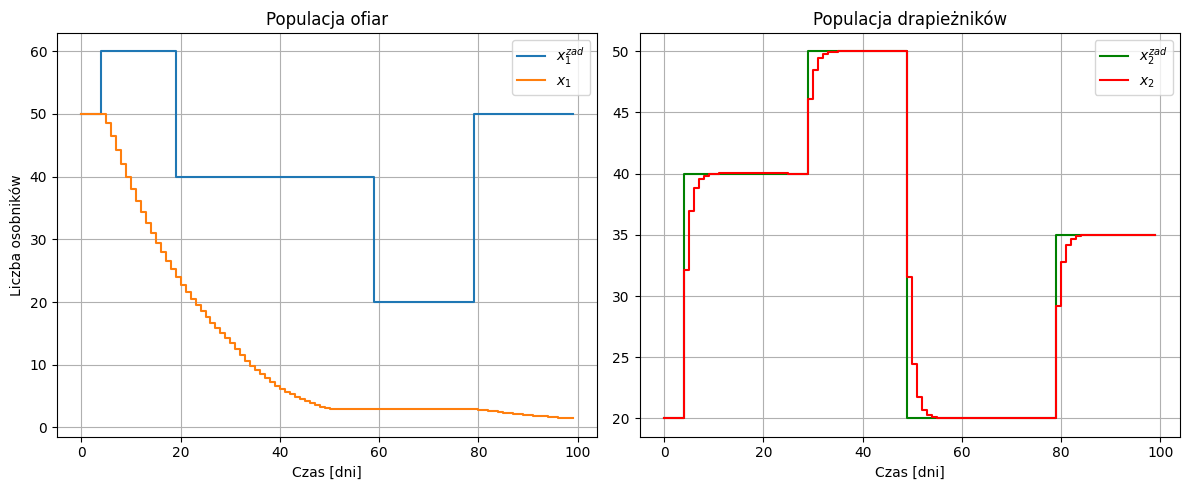

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].step(range(kmax), y_zad[:, 0], label=r"$x_1^{zad}$")
axs[0].step(range(kmax), x[0:kmax, 0], label=r"$x_1$")
axs[0].set_title("Populacja ofiar")
axs[0].set_ylabel("Liczba osobników")
axs[0].set_xlabel("Czas [dni]")
axs[0].legend(loc='upper right')
axs[0].grid()

axs[1].step(range(kmax), y_zad[:, 1], label=r"$x_2^{zad}$", c='g')
axs[1].step(range(kmax), x[0:kmax, 1], label=r"$x_2$", c='r')
axs[1].set_title("Populacja drapieżników")
axs[1].set_xlabel("Czas [dni]")
axs[1].legend(loc='upper right')
axs[1].grid()

plt.tight_layout()
plt.show()

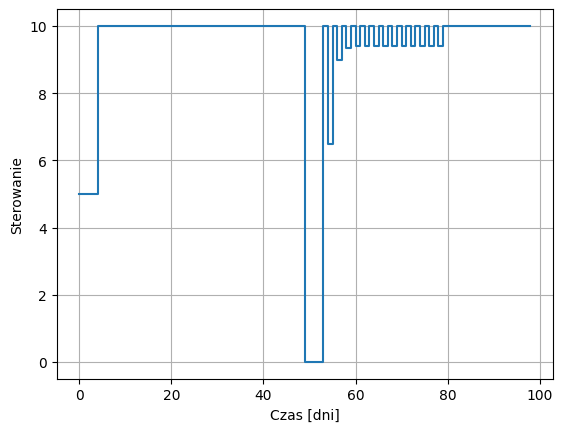

In [7]:
plt.step(range(kmax-1), u[0:kmax-1])
plt.xlabel("Czas [dni]")
plt.ylabel("Sterowanie")
plt.grid()
plt.show()